# Proper probability density diagnostic summary

In [1]:
import hypothesis
import numpy as np
import glob
import matplotlib
import plotting
import matplotlib.pyplot as plt
import torch

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from matplotlib import rc
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_pdf_abc
from plotting import compute_2d_pdf_abc
from plotting import plot_1d_pdf
from plotting import plot_2d_pdf
from plotting import plot_1d_pdf_std
from plotting import plot_1d_contours
from plotting import plot_2d_contours
from plotting import plot_stream
from tqdm import tqdm
from util import load_ratio_estimator
from util import MarginalizedAgePrior

## Utilities

In [2]:
def load_mlp(batchnorm=False, marginalized=False):
    data = []
    query = "out/coverage/4096/"
    if marginalized:
        query += "marginalized/"
    else:
        query += "not-marginalized/"
    query += "selu/integrand*mlp"
    if batchnorm:
        query += "-bn"
    query += "-0*"
    paths = glob.glob(query)
    for p in paths:
        data.append(np.load(p))
    data = np.vstack(data).reshape(-1)
    
    return np.mean(data), np.std(data), data

In [3]:
def load_resnet_18(batchnorm=False, marginalized=False):
    data = []
    query = "out/coverage/4096/"
    if marginalized:
        query += "marginalized/"
    else:
        query += "not-marginalized/"
    query += "selu/integrand*resnet-18"
    if batchnorm:
        query += "-bn"
    query += "-0*"
    paths = glob.glob(query)
    for p in paths:
        data.append(np.load(p))
    data = np.vstack(data).reshape(-1)
    
    return np.mean(data), np.std(data), data

In [4]:
def load_resnet_50(batchnorm=False, marginalized=False):
    data = []
    query = "out/coverage/4096/"
    if marginalized:
        query += "marginalized/"
    else:
        query += "not-marginalized/"
    query += "selu/integrand*resnet-50"
    if batchnorm:
        query += "-bn"
    query += "-0*"
    paths = glob.glob(query)
    for p in paths:
        data.append(np.load(p))
    data = np.vstack(data).reshape(-1)
    
    return np.mean(data), np.std(data), data

## Results

In [5]:
m, s, _ = load_mlp(batchnorm=False, marginalized=True)

m, s

(1.0228676990449659, 0.10857966706179639)

In [6]:
m, s, _ = load_mlp(batchnorm=True, marginalized=True)

m, s

(1.0374566584306062, 0.08983811625497033)

In [7]:
m, s, _ = load_resnet_18(batchnorm=False, marginalized=True)

m, s

(1.0013332928971723, 0.025556004633120695)

In [8]:
m, s, _ = load_resnet_18(batchnorm=True, marginalized=True)

m, s

(0.9751884799879083, 0.029787141474727986)

In [9]:
m, s, _ = load_resnet_50(batchnorm=False, marginalized=True)

m, s

(0.9936768851143731, 0.034502260006825436)

In [10]:
m, s, _ = load_resnet_50(batchnorm=True, marginalized=True)

m, s

(1.001464430146705, 0.0376040221619753)

## Consistency of the integrated area

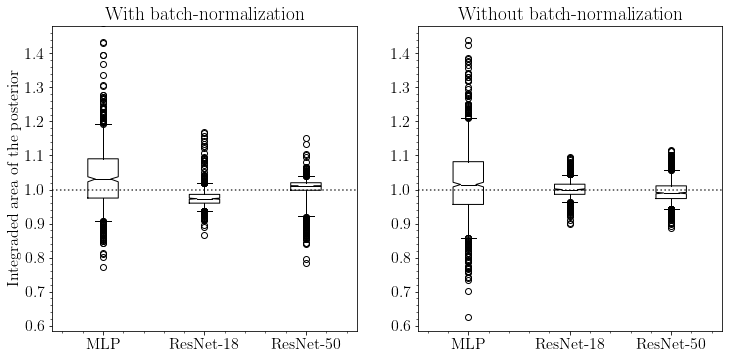

In [11]:
horizontal = True
outliers = True
notch = True
props = dict(color="black")

xlabels = ["MLP", "ResNet-18", "ResNet-50"]

if horizontal:
    figure, axes = plt.subplots(1, 2, figsize=(12, 6))
else: # Vertical
    figure, axes = plt.subplots(2, 1, figsize=(6, 12))

# Set nominal target
axes[0].axhline(1, alpha=.75, linestyle=':', color="black")
axes[1].axhline(1, alpha=.75, linestyle=':', color="black")
    
# With batch-normalization
ax = axes[0]
ax.set_title("With batch-normalization")
ax.set_ylabel("Integraded area of the posterior")
ax.minorticks_on()

_, _, values_mlp = load_mlp(batchnorm=True, marginalized=True)
_, _, values_resnet_18 = load_resnet_18(batchnorm=True, marginalized=True)
_, _, values_resnet_50 = load_resnet_50(batchnorm=True, marginalized=True)
values = np.vstack([values_mlp, values_resnet_18, values_resnet_50]).T
ax.boxplot(values, showfliers=outliers, notch=notch, bootstrap=10000, medianprops=props, whis=(5, 95))
ax.set_xticklabels(xlabels)

# Without batch-normalization
ax = axes[1]
if not horizontal:
    ax.set_ylabel("Integraded area of the posterior")
ax.set_title("Without batch-normalization")
ax.minorticks_on()

_, _, values_mlp = load_mlp(batchnorm=False, marginalized=True)
_, _, values_resnet_18 = load_resnet_18(batchnorm=False, marginalized=True)
_, _, values_resnet_50 = load_resnet_50(batchnorm=False, marginalized=True)
values = np.vstack([values_mlp, values_resnet_18, values_resnet_50]).T
ax.boxplot(values, showfliers=outliers, notch=notch, bootstrap=10000, medianprops=props, whis=(5, 95))
ax.set_xticklabels(xlabels)

# Set the y-lims
ylim_0 = axes[0].get_ylim()
ylim_1 = axes[1].get_ylim()
lower = min([ylim_0[0], ylim_1[0]])
upper = max([ylim_1[1], ylim_1[1]])
axes[0].set_ylim([lower, upper])
axes[1].set_ylim([lower, upper])

# Make the axes square
make_square(axes[0])
make_square(axes[1])

if horizontal:
    path = "plots/integrand-boxplot-horizontal.pdf"
else:
    path = "plots/integrand-boxplot-vertical.pdf"

figure.savefig(path, bbox_inches="tight")
figure.show()